In [1]:
import sys, os
import numpy as np
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

local_path = '/Users/halvardbariller/Desktop/M2_MVA/_SEMESTER_1/PGM/Project/Score-matching-project-'
sys.path.append(local_path)

%load_ext autoreload
%autoreload 2

import dataset
from dataset import sampling, densities, scores, visualisation
import score_matching
from score_matching import toy_models, learning_objectives, score_visualisation
import mcmc_sampling
from mcmc_sampling import langevin, dynamics_plot, interacting_mcmc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data creation

### GMM

In [2]:
# Parameters
N = 10000
mus = [np.array([0, 0]), np.array([10,10])]
sigmas = [np.eye(2), np.eye(2)]
alphas = [0.2, 0.8]

# Dataset
gmm_data, clusters = sampling.gaussian_mixture_sampling(mus, sigmas, alphas, N)

# Annealed Langevin Dynamics

## NCSN Training

In [3]:
# Parameters

learning_rate = 1e-3
num_epochs = 1000

sigma_begin = 1 
sigma_end = 0.01
num_levels = 10 # number of sigmas to generate, in the paper it's represent as L 

## vector of num_classes of sigmas to use for data pertubation 
noise_levels = torch.tensor(np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_levels))).float() 

# Our approximation model
ncsn = toy_models.ConditionalModel(num_levels)

# Learning objective
optimizer = torch.optim.Adam(ncsn.parameters(), lr=learning_rate)
ScoreMatching = learning_objectives.ScoreMatching(optimizer, 'anneal_denoising_score_matching', device, sigma = noise_levels) # sigmas here is for data's pertubation 

In [4]:
ScoreMatching.train(gmm_data, ncsn, num_epochs, verbose=False, plot=False)

100%|██████████| 1000/1000 [00:24<00:00, 40.48it/s]

Training finished!


## Annealed Langevin Sampling

In [5]:
step = 1e-4
iterations = 300
n_samples = 10000

target_samples_annealed, hist_samples_annealed = interacting_mcmc.annealed_langevin(ncsn, step, noise_levels, 
                                                                                    iterations, n_samples, **{'data_type':'gmm'})

100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


In [8]:
# Samples without annealing
gmm_samples = langevin.unnadjusted_langevin_sampling(scores.gaussian_mixture_score, 1e-2, 
                                                     iterations, 1000, mus, sigmas, alphas)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:12<00:00, 80.69it/s]


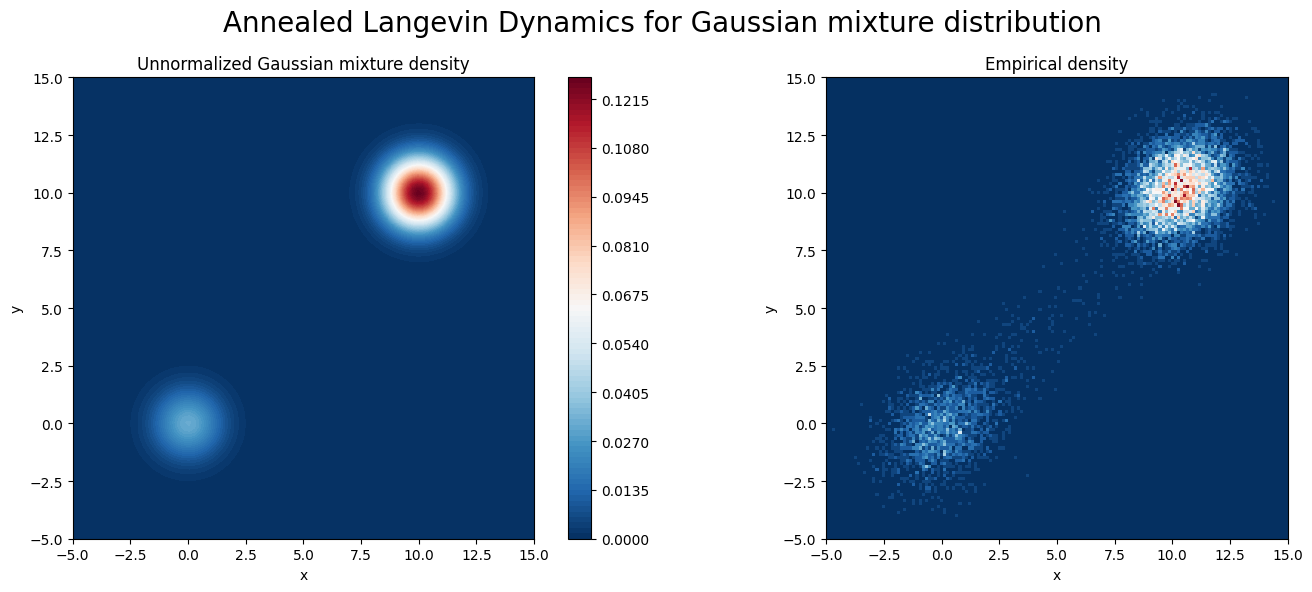

In [6]:
dynamics_plot.langevin_sampling_gmm(target_samples_annealed, mus, sigmas, alphas, annealed=True)

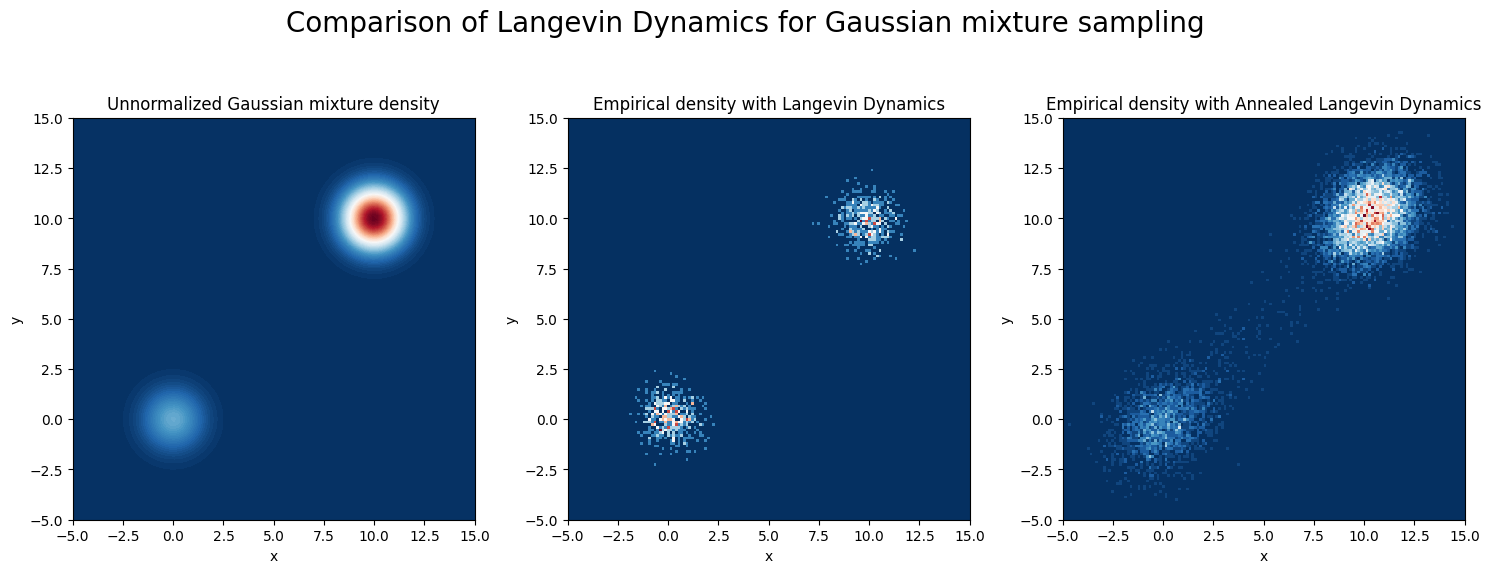

In [9]:
dynamics_plot.annealed_langevin_sampling_comparison(gmm_samples, target_samples_annealed, mus, sigmas, alphas)

## Parallel Tempering with Score proposals

In [3]:
# Parameters
learning_rate = 1e-3
hidden_size = 128
num_epochs = 1000
# Model
sliced_score_network = toy_models.ToyScoreNetwork(hidden_size=hidden_size).to(device)
optimizer = torch.optim.Adam(sliced_score_network.parameters(), lr=learning_rate)
SlicedScoreMatching = learning_objectives.ScoreMatching(optimizer, 'sliced_score_matching', device)
# Training
SlicedScoreMatching.train(gmm_data, sliced_score_network, num_epochs, verbose=False, plot=False)

100%|██████████| 1000/1000 [00:32<00:00, 30.66it/s]

Training finished!


In [6]:
temperatures = np.array([30., 15., 5., 2., 1.])

pt_trajectories, pt_mh_acceptances, pt_swap_acceptances = interacting_mcmc.parallel_tempering(temperatures, 
                                                                             10000, sliced_score_network, mus, sigmas, alphas)

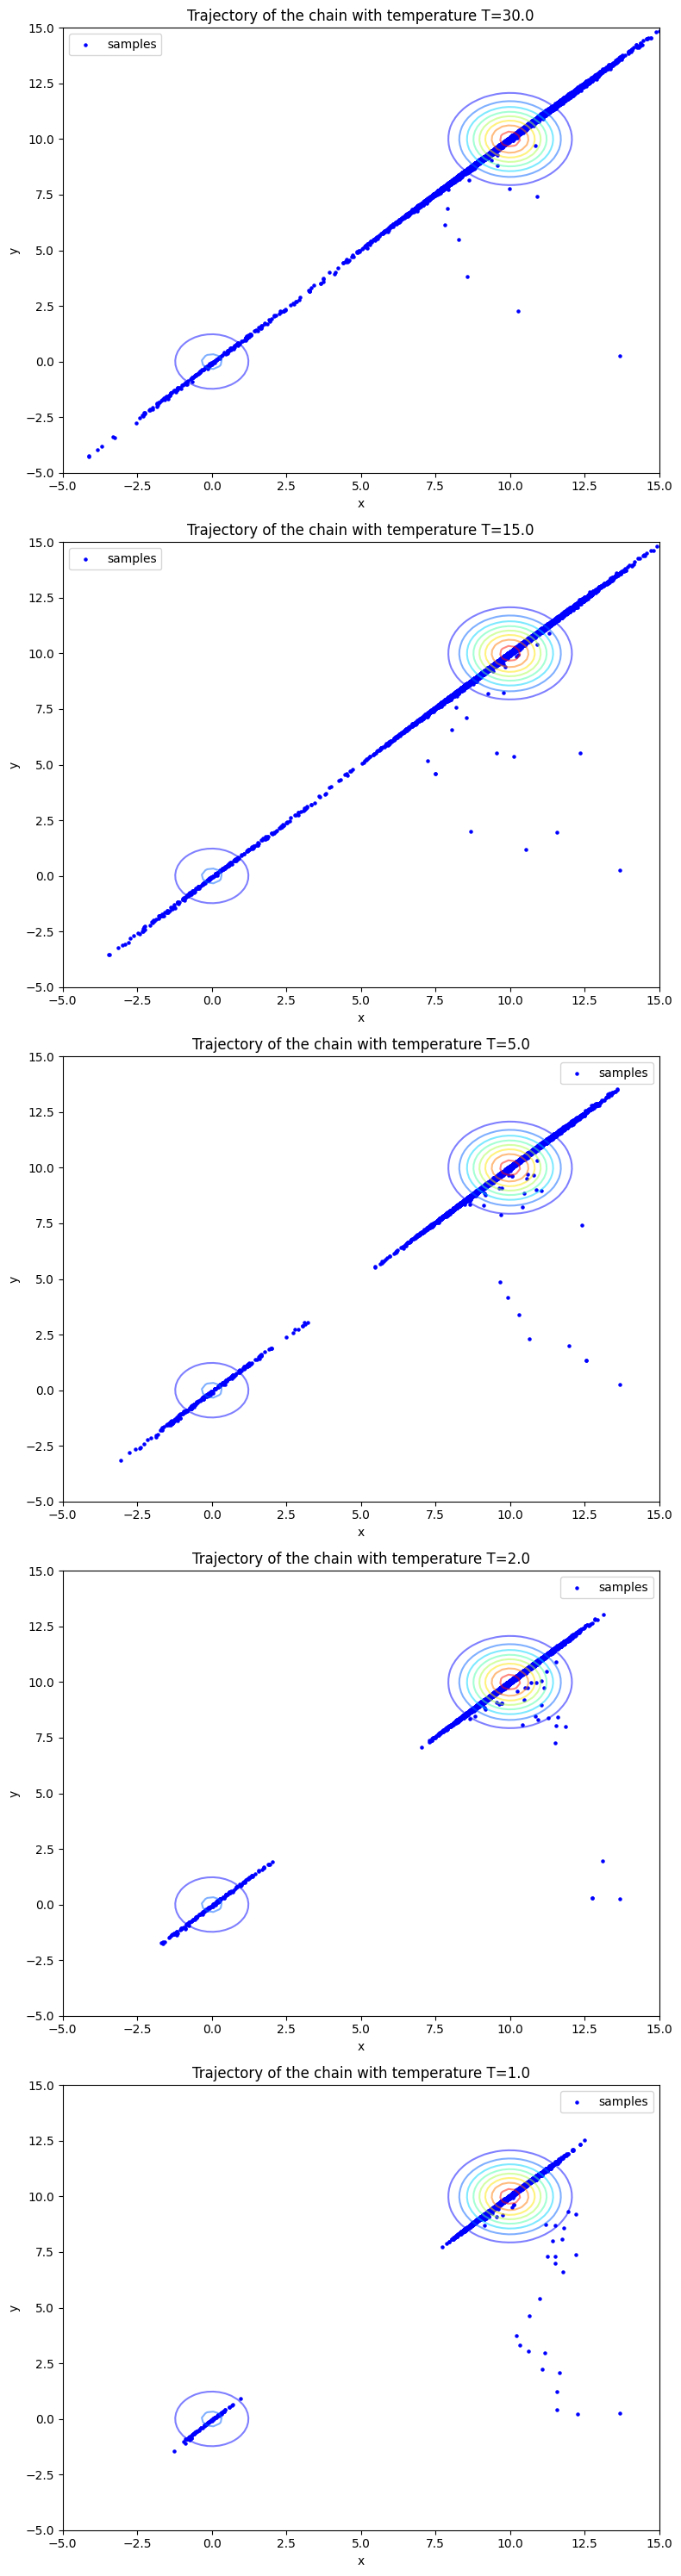

In [7]:
x_lim = (-5, 15)
y_lim = (-5, 15)

X = np.linspace(x_lim[0], x_lim[1], 100)
Y = np.linspace(y_lim[0], y_lim[1], 100)
xx, yy = np.meshgrid(X, Y)
Z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z[i,j] = np.exp(densities.gmm_log_density(np.array([xx[i,j], yy[i,j]]), mus, sigmas, alphas))

K = temperatures.shape[0]

fig, ax = plt.subplots(K, 1, figsize=(8, 30))

for i in range(temperatures.shape[0]):
    ax[i].set_xlim(x_lim)
    ax[i].set_ylim(y_lim)
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_title('Trajectory of the chain with temperature T={}'.format(temperatures[i]))
    ax[i].contour(X, Y, Z, 10, cmap='jet', alpha = 0.5)

for i in range(K):
    ax[i].scatter([z[0] for z in pt_trajectories[:,i]], [z[1] for z in pt_trajectories[:,i]], s=5, color = 'b', label = 'samples')
    ax[i].legend()

    
fig.tight_layout()
plt.show()
